# Direction Thought Detection

In this notebook we will train a model to determine whether a person is thinking `left`, `right`, or `none`.

## Running a Survey

First we can import our library and create a survey, so we can train a model on the resulting data. We'll ask the participant to first get into a comfortable position, think of left, think of right, think of none, etc. 3x.

In [2]:
%matplotlib notebook
# Reload external source files when they change
%load_ext autoreload
%autoreload 2
import sys
from datetime import timedelta, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../src")
from recorder import Muse2EEGRecorder
from survey import Survey

left_step = (timedelta(seconds=30), "left", "Think about going left.", True)
right_step = (timedelta(seconds=30), "right", "Think about going right.", True)
none_step = (timedelta(seconds=30), "none", "Just breathe.", True)
direction_schedule = [
    (timedelta(seconds=30), "intro", "Just breathe normally, gently relax any tension, and get into a comfortable position.", False),
    left_step,
    right_step,
    none_step,
    left_step,
    right_step,
    none_step,
    left_step,
    right_step,
    none_step
]

test_schedule = [
    (timedelta(seconds=5), "intro", "Just breathe normally, gently relax any tension, get in a comfortable position.", True)
]

#muse2_recorder = Muse2EEGRecorder()
#direction_survey = Survey(muse2_recorder, "Left-Right Thoughts", "Thinking 'left' for 30s, then 'right', then 'none' - repeat 3x.", direction_schedule)
#direction_survey.record("Jared")

## Preparing Data for Learning

In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader

from eeg_preprocessing import preprocess_eeg_channel
from eegdata import EEGSurveyDataset, ChunkedDataset, MultiDataset

def transform_normalize(data):
    for ch in range(data.shape[1]):
        data[:, ch] = preprocess_eeg_channel(data[:, ch])
        stddev = data[:, ch].std()
        if stddev != 0:
            data[:, ch] = (data[:, ch] - data[:, ch].mean()) / stddev
    return data

batch_size = 35

# XXX TODO: modify EEGSurveyDataset to return one-hot labels.
# Create PyTorch Datasets
ds1 = EEGSurveyDataset("../data/muse2-recordings/surveys/Left-Right Thoughts Jared 2021-06-28 20:58:50.989498", 7665, transform=transform_normalize)
ds2 = EEGSurveyDataset("../data/muse2-recordings/surveys/Left-Right Thoughts Jared 2021-06-30 11:59:08.126713", 7665, transform=transform_normalize)
ds3 = EEGSurveyDataset("../data/muse2-recordings/surveys/Left-Right Thoughts Jared 2021-07-01 16:34:42.871336", 7665, transform=transform_normalize)
ds1, ds2, ds3 = ChunkedDataset(ds1, batch_size), ChunkedDataset(ds2, batch_size), ChunkedDataset(ds3, batch_size)
train_dataset = MultiDataset([ds1, ds3])
test_dataset = MultiDataset([ds2])
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

## PyTorch Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

n_channels = 4
n_outputs = 3

# Create model
net = nn.Sequential(
    # Pass input to a 1D convolutional layer with a kernel size of 3, apply to activation function.
    nn.Conv1d(n_channels, 32, 3),
    nn.ReLU(),

    # Pass previous layer output to a 1D convolutional layer with a kernel size of 2, apply to activation function,
    # and get the max value from each kernel.
    nn.Conv1d(32, 32, 2),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),

    # Pass previous layer output to a 1D convolutional layer with a kernel size of 2, apply to activation function,
    # and get the max value from each kernel. (same as previous layer)
    nn.Conv1d(32, 32, 2),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),

    # Flatten the convolutions. Input shape: (a, b, c), Output shape: (a, b*c)
    nn.Flatten(),
    
    #nn.Dropout(0.5),
    # ?
    # XXX: The first number needs to be updated each time the input shapes change. We could instead
    #      Create a class-based Module, and do a single pass through the conv portion of the network
    #      in order to determine the actual size.
    #      (This technique is shown in https://www.youtube.com/watch?v=1gQR24B3ISE&list=PLQVvvaa0QuDdeMyHEYc0gxFpYwHY2Qfdh&index=7).
    #      For now, we can update this value as needed by commenting out all layers after Flatten(), then running the code
    #      below and inspecting the output shape. The x[1] value should be the first arg in the following line.
    nn.Linear(1696, 512),  # ~= nn.LazyLinear(512)

    # Flatten the linear layer into the required number of outputs
    nn.Linear(512, n_outputs),
    nn.Softmax()
)

for i, data in enumerate(train_dataloader, 0):
    features, labels = data
    print("Model input shape:", features.shape)
    out = net(features.float())
    print(out)
    print("Model output shape:", out.shape)
    break

Model input shape: torch.Size([35, 4, 219])
tensor([[0.3217, 0.3396, 0.3386],
        [0.3252, 0.3373, 0.3375],
        [0.3231, 0.3373, 0.3396],
        [0.3170, 0.3469, 0.3360],
        [0.3073, 0.3551, 0.3375],
        [0.3200, 0.3398, 0.3402],
        [0.3249, 0.3352, 0.3399],
        [0.3153, 0.3442, 0.3405],
        [0.3200, 0.3377, 0.3423],
        [0.3236, 0.3352, 0.3412],
        [0.3214, 0.3392, 0.3394],
        [0.3270, 0.3373, 0.3358],
        [0.3218, 0.3393, 0.3390],
        [0.3227, 0.3362, 0.3410],
        [0.3259, 0.3410, 0.3331],
        [0.3239, 0.3396, 0.3364],
        [0.3225, 0.3368, 0.3407],
        [0.3212, 0.3385, 0.3403],
        [0.3221, 0.3374, 0.3405],
        [0.3223, 0.3391, 0.3387],
        [0.3200, 0.3462, 0.3339],
        [0.3226, 0.3338, 0.3436],
        [0.3322, 0.3392, 0.3286],
        [0.3216, 0.3429, 0.3355],
        [0.3184, 0.3434, 0.3382],
        [0.3199, 0.3397, 0.3404],
        [0.3198, 0.3411, 0.3392],
        [0.3190, 0.3411, 0.3399],
    

/home/jared/.local/share/virtualenvs/neurothink--t8FFcF9/lib/python3.9/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/jared/.local/share/virtualenvs/neurothink--t8FFcF9/lib/python3.9/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


## Training the Model

100%|██████████| 50/50 [00:35<00:00,  1.43it/s]

Passes per epoch: 18.0
Final Loss: 0.6409163475036621
Final Accuracy: 36%


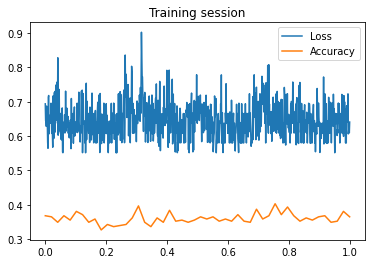

In [11]:
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train for n epochs
n = 50
test_while_training = True

loss_history = []
eval_history = []
count = 0
net.train()
for epoch in tqdm(range(n)):
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data

        # Zero gradients
        optimizer.zero_grad()
        #net.zero_grad()

        # Forward
        predictions = net(features.float())
        
        # Compute loss
        loss = criterion(predictions, labels.long())
        loss_history.append(loss.item())
        
        # Backward
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        count += 1
        
    # Evaluate the model against the test dataset
    if test_while_training:
        total = 0
        correct = 0
        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                features, labels = data
                out = net(features.float())
                #print(labels.shape)
                preds = F.log_softmax(out, dim=1).argmax(dim=1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        eval_history.append(correct / total)

%matplotlib inline
plt.title("Training session")
print("Passes per epoch:", count / n)
print("Final Loss:", loss_history[-1])
plt.plot(np.linspace(0, 1, len(loss_history)), loss_history, label="Loss")
if test_while_training:
    print(f"Final Accuracy: {int(100*eval_history[-1])}%")
    plt.plot(np.linspace(0, 1, len(eval_history)), eval_history, label="Accuracy")
plt.legend()
plt.show()

In [10]:
net.eval()
total = 0
correct = 0
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        features, labels = data
        out = net(features.float())
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

model_accuracy = int(correct / total * 100)
print("Correct:", correct, "/", total, "-", f"{model_accuracy}%")

Correct: 116 / 315 - 36%


/home/jared/.local/share/virtualenvs/neurothink--t8FFcF9/lib/python3.9/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


## Saving the Model

In [ ]:
timestamp = str(datetime.now())
torch.save(net.state_dict(), f"../models/{timestamp}-Muse_EEG_eyes_open-{model_accuracy}percent.pt")
with open(f"../models/{timestamp}-Muse_EEG_eyes_open-{model_accuracy}percent.model", "w") as f:
    f.write(str(net))

<IPython.core.display.Javascript object>


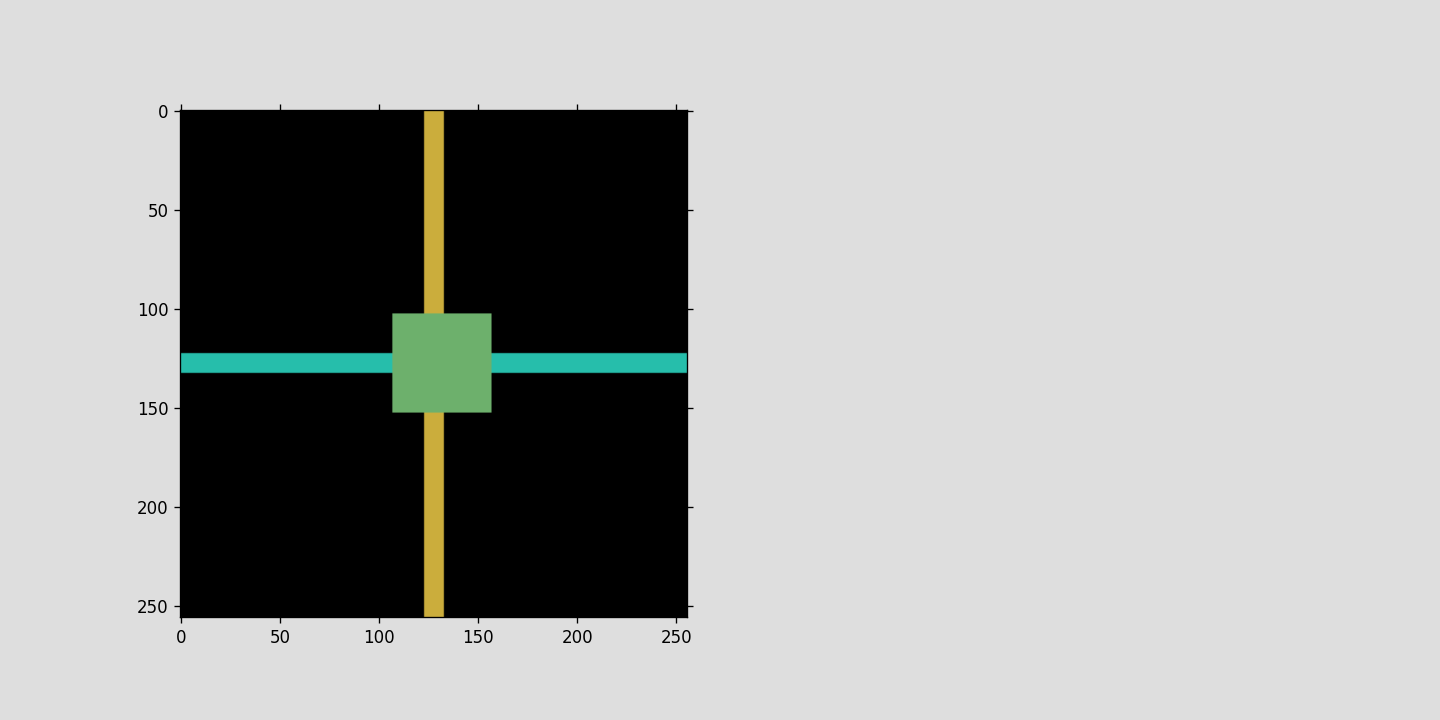

In [16]:
import cv2
import time

fig = plt.figure(figsize=(12,6), facecolor='#DEDEDE')
ax = plt.subplot(121)
#ax1 = plt.subplot(122)
#ax.set_facecolor('#DEDEDE')
#ax1.set_facecolor('#DEDEDE')

WIDTH=256
HEIGHT=256

SQ_SIZE = 50
MOVE_SPEED = 1

square = {'x1': int(int(WIDTH)/2-int(SQ_SIZE/2)), 
          'x2': int(int(WIDTH)/2+int(SQ_SIZE/2)),
          'y1': int(int(HEIGHT)/2-int(SQ_SIZE/2)),
          'y2': int(int(HEIGHT)/2+int(SQ_SIZE/2))}

box = np.ones((square['y2']-square['y1'], square['x2']-square['x1'], 3)) * np.random.uniform(size=(3,))
horizontal_line = np.ones((HEIGHT, 10, 3)) * np.random.uniform(size=(3,))
vertical_line = np.ones((10, WIDTH, 3)) * np.random.uniform(size=(3,))

for i in range(5):
    # Create img
    env = np.zeros((WIDTH, HEIGHT, 3))
    env[:,HEIGHT//2-5:HEIGHT//2+5,:] = horizontal_line
    env[WIDTH//2-5:WIDTH//2+5,:,:] = vertical_line
    env[square['y1']:square['y2'], square['x1']:square['x2']] = box
    # Clear current plot
    ax.cla()
    # Show img
    plt.imshow(cv2.cvtColor(np.float32(env), cv2.COLOR_BGR2RGB))
    #plt.show()
    
    # Update square position
    move = 1 * MOVE_SPEED
    square['x1'] += move
    square['x2'] += move
    
    time.sleep(0.5)